# **KRITI GB ELECTRICITY MARKET**

**IMPORT LIBRARIES**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import re

import warnings
from warnings import filterwarnings
filterwarnings('ignore')

 **DATA FETCHING AND PROCESSING**

In [ ]:
# Path where the CSV files are stored
folder_path = "/content/sample_data"

files = [f for f in os.listdir(folder_path) if f.startswith("MarketIndexPrices") and f.endswith(".csv")]

def extract_date(filename):
    match = re.search(r"(\d{4}-\d{2}-\d{2})T", filename)
    return datetime.strptime(match.group(1), "%Y-%m-%d") if match else None

# Sort files based on the date
files.sort(key=extract_date)

dataframes = []
for file in files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    df = df.iloc[::-1].reset_index(drop=True)

    df = df[~df.apply(lambda row: row.astype(str).str.contains("N2EXMIDP").any(), axis=1)]

    dataframes.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_csv("MarketIndexPrices.csv", index=False)

print("All files combined successfully, with 'N2EXMIDP' rows removed!")
print(combined_df.shape)

All files combined successfully, with 'N2EXMIDP' rows removed!
(39569, 6)


In [ ]:
file_path = "MarketIndexPrices.csv"
df = pd.read_csv(file_path)

df['StartTime'] = pd.to_datetime(df['StartTime'])

# Deleting duplicate entries
df.drop_duplicates(inplace=True)

df.set_index('StartTime', inplace=True)

# Introducing missing entries
full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='30T')

df = df.reindex(full_time_range)

# Handling missing values using interpolation
df.interpolate(method='linear', inplace=True)

df.reset_index(inplace=True)
df.rename(columns={'index': 'StartTime'}, inplace=True)

df.to_csv("Cleaned_MarketIndexPrices.csv", index=False)

print("Duplicate rows removed, missing half-hour periods filled, and dataset cleaned successfully!")
print(df.shape)

In [5]:
Data = pd.read_csv("Cleaned_MarketIndexPrices.csv")
Data.head()

Data['StartTime'] = pd.to_datetime(Data['StartTime'])
Data.set_index('StartTime', inplace=True)

Latest_Date = Data.index.max()
Three_Months_Ago = Latest_Date - pd.DateOffset(months=3)


# Extracting the data for the Analysis Period
Analysis_Data = Data[Data.index <= Three_Months_Ago]


**REGIME IDENTIFICATION**

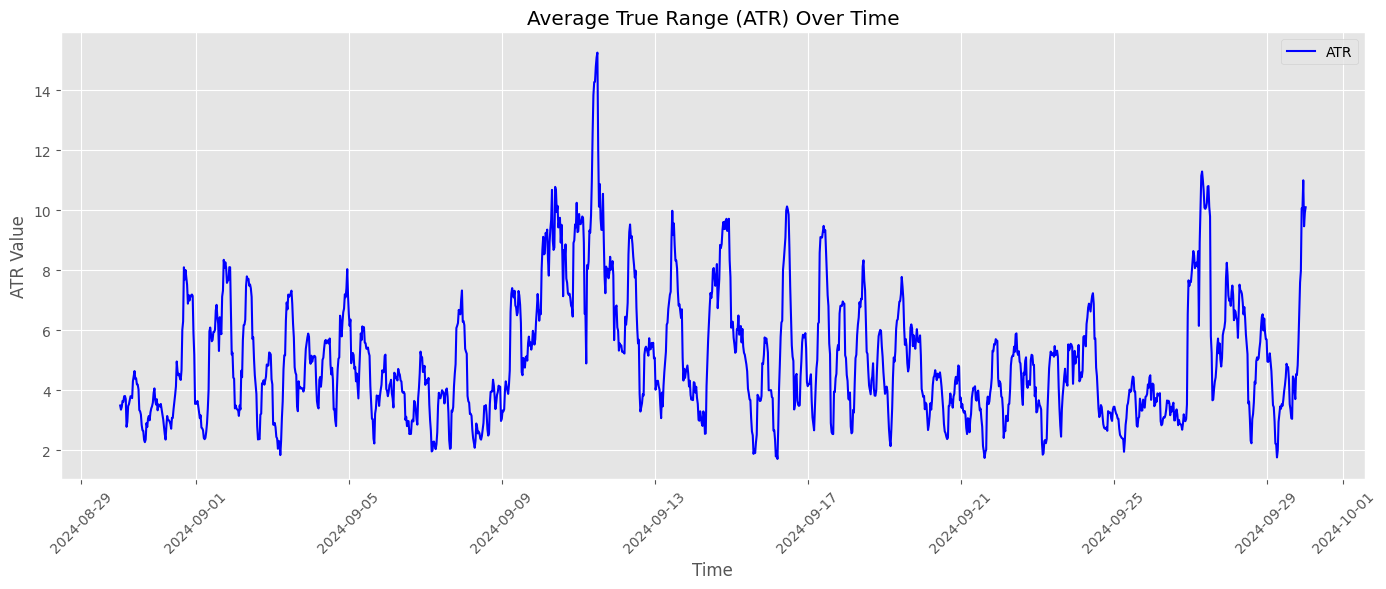

,DataProvider,SettlementDate,SettlementPeriod,Price,Volume,Price Change,ATR
StartTime,,,,,,,
2022-10-01 00:00:00+00:00,APXMIDP,2022-10-01,3.0,124.99,613.70,NaN,NaN
2022-10-01 00:30:00+00:00,APXMIDP,2022-10-01,4.0,144.17,882.70,19.18,NaN
2022-10-01 01:00:00+00:00,APXMIDP,2022-10-01,5.0,147.72,1032.25,3.55,NaN
2022-10-01 01:30:00+00:00,APXMIDP,2022-10-01,6.0,101.15,857.75,46.57,NaN
2022-10-01 02:00:00+00:00,APXMIDP,2022-10-01,7.0,102.35,1254.85,1.20,NaN


In [6]:
def analyze_volatility_with_atr(data, periods=14, plot = False):
    """
    Calculates the Average True Range (ATR) and plots it over time for the last month.

    """

    data['Price Change'] = data['Price'].diff().abs()
    data['ATR'] = data['Price Change'].shift(1).rolling(window=periods).mean()

    if plot:

      latest_date = data.index.max()
      one_month_ago = latest_date - pd.DateOffset(months=1)

      df_filtered = data[data.index >= one_month_ago]

      plt.style.use('ggplot')
      plt.figure(figsize=(14, 6))
      plt.plot(df_filtered.index, df_filtered['ATR'], label='ATR', color='blue')
      plt.title('Average True Range (ATR) Over Time')
      plt.xlabel('Time')
      plt.ylabel('ATR Value')
      plt.xticks(rotation=45)
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

analyze_volatility_with_atr(Analysis_Data,14,True)
analyze_volatility_with_atr(Data)
Data.head()

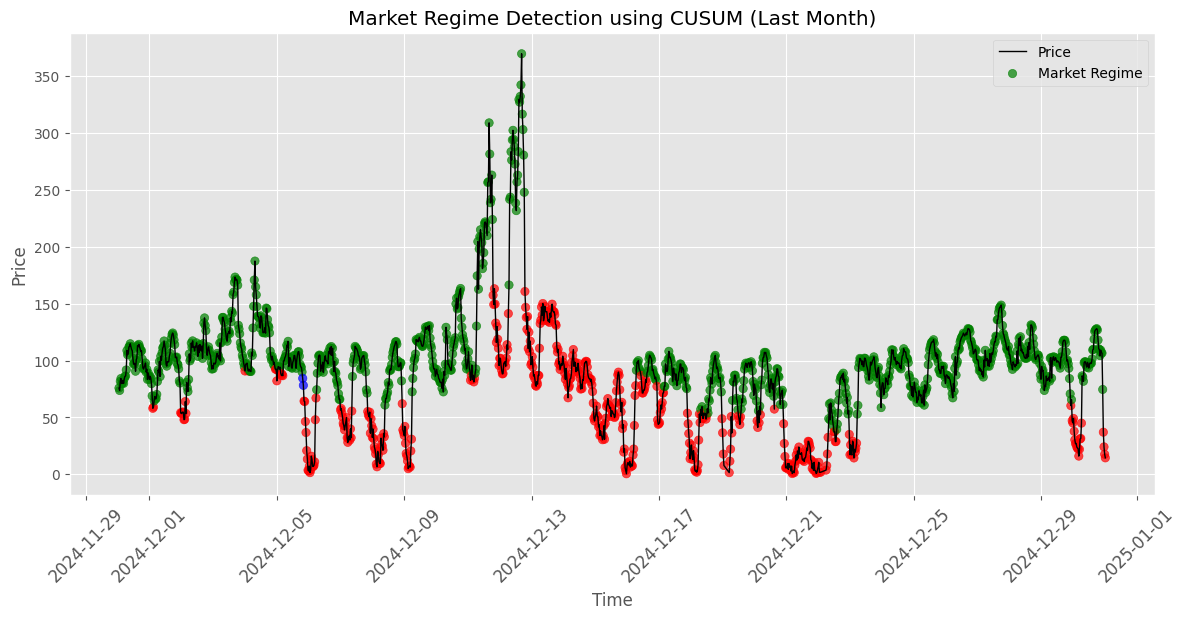

In [8]:
def analyze_market_regime(data, lookback_period='1M', plot=False):
    """
    Analyzes and identifies market regimes using the CUSUM method on logarithmic returns.

    """
    data = data.copy()

    data = data[data['Price'] > 0]

    data['Log_Return'] = np.log(data['Price']).diff()

    data.dropna(subset=['Log_Return'], inplace=True)

    def cusum(series, threshold=0.005):

        pos_cusum = np.zeros(len(series))
        neg_cusum = np.zeros(len(series))

        for i in range(1, len(series)):
            pos_cusum[i] = max(0, pos_cusum[i - 1] + series.iloc[i] - threshold)
            neg_cusum[i] = min(0, neg_cusum[i - 1] + series.iloc[i] + threshold)

        return pd.Series(pos_cusum, index=series.index), pd.Series(neg_cusum, index=series.index)

    data['CUSUM_Pos'], data['CUSUM_Neg'] = cusum(data['Log_Return'])

    data['Regime'] = 'Stagnant'

    data.loc[data['CUSUM_Pos'] > data['CUSUM_Pos'].shift(1).std(), 'Regime'] = 'Bullish'

    data.loc[data['CUSUM_Neg'] < -data['CUSUM_Neg'].shift(1).std(), 'Regime'] = 'Bearish'

    color_map = {'Bullish': 'green', 'Bearish': 'red', 'Stagnant': 'blue'}
    data['Color'] = data['Regime'].map(color_map)

    if plot:

      df_last_month = data.last("1M")

      plt.figure(figsize=(14, 6))
      plt.plot(df_last_month.index, df_last_month['Price'], color='black', label="Price", linewidth=1)
      plt.scatter(df_last_month.index, df_last_month['Price'], c=df_last_month['Color'], label="Market Regime", alpha=0.7)
      plt.title("Market Regime Detection using CUSUM (Last Month)")
      plt.xlabel("Time")
      plt.xticks(rotation=45, fontsize=12)
      plt.ylabel("Price")
      plt.legend()
      plt.show()
    return data

Data = analyze_market_regime(Data, plot=True)
Analysis_Data = analyze_market_regime(Analysis_Data)

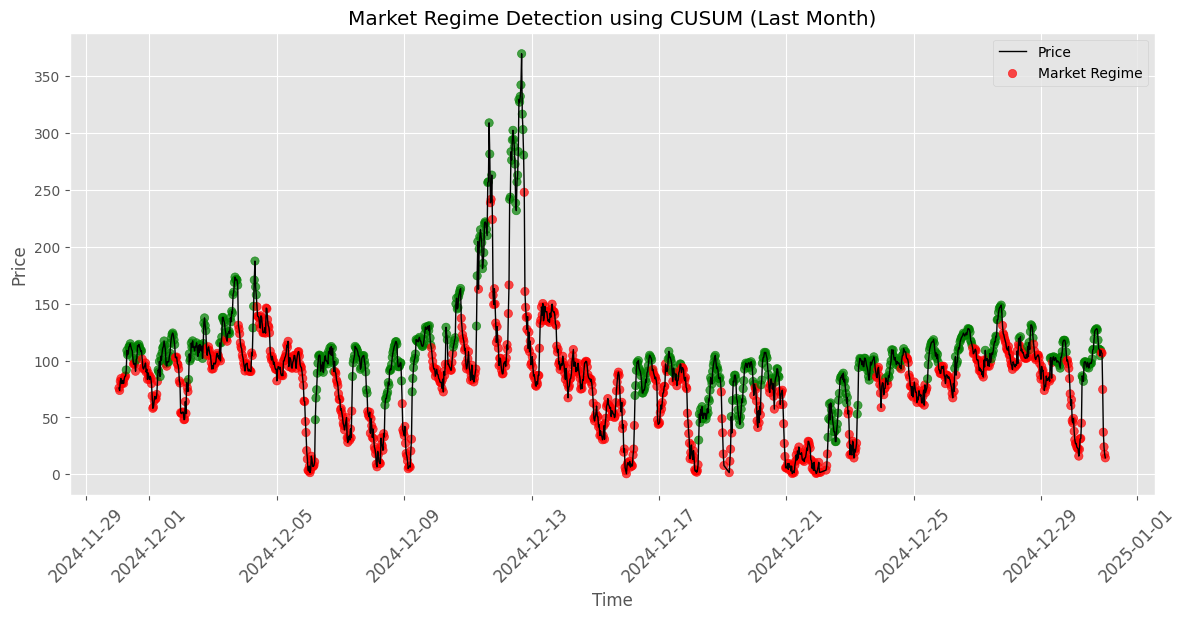

In [9]:

def analyze_market_regime(data, lookback_period='1M', window_size=30, plot=False):
    """
    Analyzes and identifies market regimes using the CUSUM method on logarithmic returns.
    Uses a fixed window size for the rolling standard deviation to avoid lookahead bias.
    """
    data = data.copy()  # Creates a copy of the DataFrame to avoid modifying the original data.

    data = data[data['Price'] > 0]  # Filters out any rows where the 'Price' column has non-positive values.

    data['Log_Return'] = np.log(data['Price']).diff()  # Computes the logarithmic returns of the 'Price' column.

    data.dropna(subset=['Log_Return'], inplace=True)  # Drops rows where 'Log_Return' is NaN, which are likely from the first row after diff().

    def cusum(series, threshold=0.005):
        pos_cusum, neg_cusum = np.zeros(len(series)), np.zeros(len(series))
        for i in range(1, len(series)):
            pos_cusum[i] = max(0, pos_cusum[i - 1] + series.iloc[i] - threshold)
            neg_cusum[i] = min(0, neg_cusum[i - 1] + series.iloc[i] + threshold)
        return pd.Series(pos_cusum, index=series.index), pd.Series(neg_cusum, index=series.index)

    data['CUSUM_Pos'], data['CUSUM_Neg'] = cusum(data['Log_Return'])

    # Calculate rolling standard deviations for the CUSUM values using the specified window size
    rolling_std_pos = data['CUSUM_Pos'].rolling(window=window_size, min_periods=1).std()
    rolling_std_neg = data['CUSUM_Neg'].rolling(window=window_size, min_periods=1).std()

    data['Regime'] = 'Stagnant'
    data.loc[data['CUSUM_Pos'] > rolling_std_pos, 'Regime'] = 'Bullish'
    data.loc[data['CUSUM_Neg'] < -rolling_std_neg, 'Regime'] = 'Bearish'

    color_map = {'Bullish': 'green', 'Bearish': 'red', 'Stagnant': 'blue'}
    data['Color'] = data['Regime'].map(color_map)

    if plot:
        df_last_month = data.last(lookback_period)
        plt.figure(figsize=(14, 6))
        plt.plot(df_last_month.index, df_last_month['Price'], color='black', label="Price", linewidth=1)
        plt.scatter(df_last_month.index, df_last_month['Price'], c=df_last_month['Color'], label="Market Regime", alpha=0.7)
        plt.title("Market Regime Detection using CUSUM (Last Month)")
        plt.xlabel("Time")
        plt.xticks(rotation=45, fontsize=12)
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    return data

# Example usage
Data = analyze_market_regime(Data, plot=True)
Analysis_Data = analyze_market_regime(Analysis_Data)


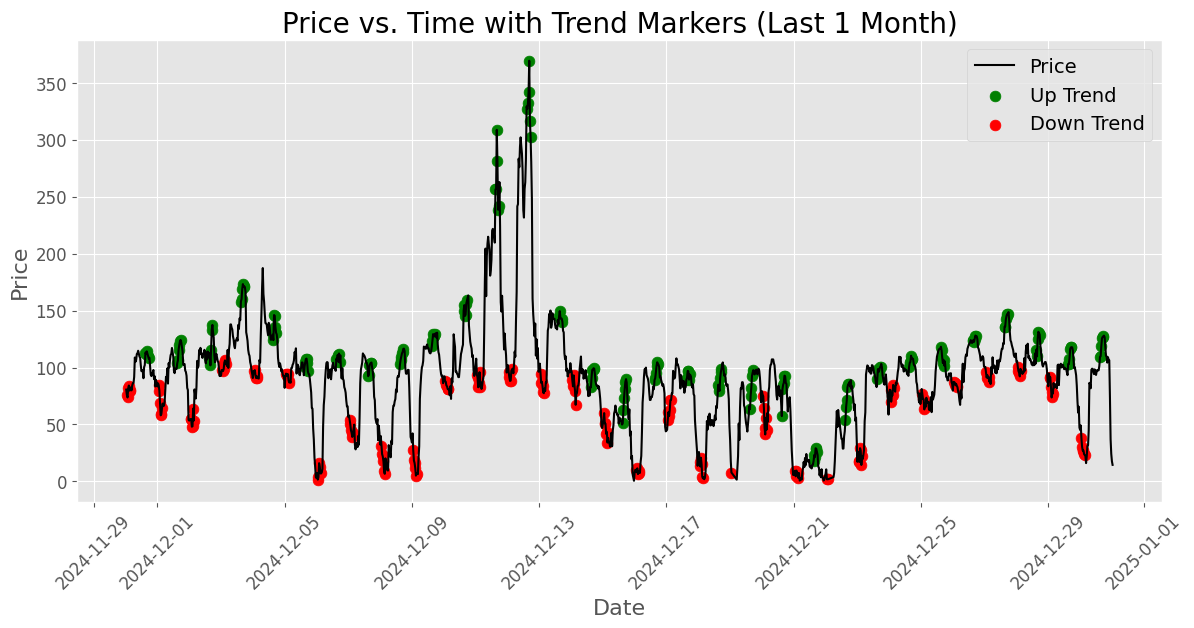

In [10]:
def hourly_regime(data, price_column='Price',plot=False):
    """
    Modifies the input DataFrame to add hourly regime analysis and plots price data highlighting these regimes.

    """
    data['Hour'] = data.index.hour

    data['Hour_Regime'] = data['Hour'].apply(lambda x: 1 if 15 <= x < 18 else (-1 if 1 <= x < 4 else 0))

    data.drop(columns=['Hour'], inplace=True)

    if plot:
      latest_date = data.index.max()
      one_month_ago = latest_date - pd.DateOffset(months=1)
      df_filtered = data[data.index >= one_month_ago]

      plt.figure(figsize=(14, 6))
      plt.plot(df_filtered.index, df_filtered[price_column], 'k-', linewidth=1.5, label='Price')

      plt.scatter(df_filtered.loc[df_filtered['Hour_Regime'] == 1].index,
                  df_filtered.loc[df_filtered['Hour_Regime'] == 1, price_column],
                  color='g', s=60, label='Up Trend')

      plt.scatter(df_filtered.loc[df_filtered['Hour_Regime'] == -1].index,
                  df_filtered.loc[df_filtered['Hour_Regime'] == -1, price_column],
                  color='r', s=60, label='Down Trend')

      plt.xlabel('Date', fontsize=16)
      plt.ylabel(price_column, fontsize=16)
      plt.title('Price vs. Time with Trend Markers (Last 1 Month)', fontsize=20)
      plt.legend(fontsize=14)
      plt.xticks(rotation=45, fontsize=12)
      plt.yticks(fontsize=12)

      plt.show()

hourly_regime(Analysis_Data)
hourly_regime(Data,plot=True)

**PRICE TRENDS IDENTIFICATON**

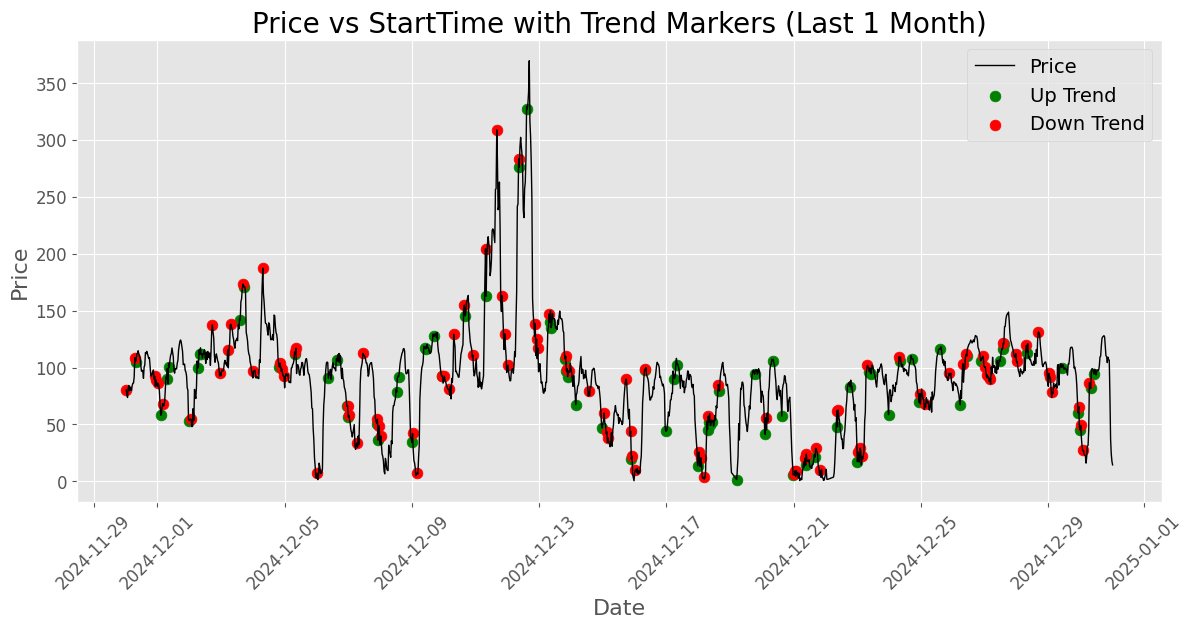

In [11]:
def analyze_and_plot_trends(data, window=20, lookback_period='1M',plot=False):
    """
    Analyzes financial data by computing Bollinger Bands, detecting trend changes using a ZigZag-like method,
    and plots trend signals over the last specified period.

    """
    data['SettlementDate'] = pd.to_datetime(data['SettlementDate'])

    data['SMA'] = data['Price'].rolling(window=window, min_periods=1).mean()
    data['STD'] = data['Price'].rolling(window=window, min_periods=1).std()
    data['Upper_Band'] = data['SMA'] + (data['STD'] * 2)
    data['Lower_Band'] = data['SMA'] - (data['STD'] * 2)

    data['Price_Change'] = data['Price'].diff()
    data['ZigZag'] = np.where(
        (data['Price_Change'] > 0) & (data['Price_Change'].shift(-1) < 0), 'Down',
        np.where((data['Price_Change'] < 0) & (data['Price_Change'].shift(-1) > 0), 'Up', 'Flat')
    )

    data['Trend_Signal'] = 0
    buy_condition = (
        ((data['Price'] > data['SMA'] + data['STD']) & (data['ZigZag'] == 'Up')) |
        ((data['Price'] < data['Lower_Band']) & (data['ZigZag'] == 'Up'))
    )
    sell_condition = (
        ((data['Price'] < data['SMA'] - data['STD']) & (data['ZigZag'] == 'Down')) |
        ((data['Price'] > data['Upper_Band']) & (data['ZigZag'] == 'Down'))
    )
    data.loc[buy_condition, 'Trend_Signal'] = 1
    data.loc[sell_condition, 'Trend_Signal'] = -1
    data['Position'] = data['Trend_Signal'].replace(to_replace=0, method='ffill')

    data['Prev_High'] = data.groupby('SettlementDate')['Price'].transform(lambda x: x.shift(1).rolling(window=48, min_periods=1).max())
    data['Prev_Low'] = data.groupby('SettlementDate')['Price'].transform(lambda x: x.shift(1).rolling(window=48, min_periods=1).min())

    if plot:

      latest_date = data.index.max()
      one_month_ago = latest_date - pd.DateOffset(months=1)
      df_filtered = data[data.index >= one_month_ago]

      plt.figure(figsize=(14,6))
      plt.plot(df_filtered.index, df_filtered['Price'], 'k-', linewidth=1, label='Price')
      plt.scatter(df_filtered.loc[df_filtered['Trend_Signal'] == 1].index,
                df_filtered.loc[df_filtered['Trend_Signal'] == 1, 'Price'],
                color='g', s=60, label='Up Trend')
      plt.scatter(df_filtered.loc[df_filtered['Trend_Signal'] == -1].index,
                df_filtered.loc[df_filtered['Trend_Signal'] == -1, 'Price'],
                color='r', s=60, label='Down Trend')
      plt.xlabel('Date', fontsize=16)
      plt.ylabel('Price', fontsize=16)
      plt.title('Price vs StartTime with Trend Markers (Last 1 Month)', fontsize=20)
      plt.legend(fontsize=14)
      plt.xticks(rotation=45, fontsize=12)
      plt.yticks(fontsize=12)
      plt.show()

analyze_and_plot_trends(Data,plot=True)
analyze_and_plot_trends(Analysis_Data)

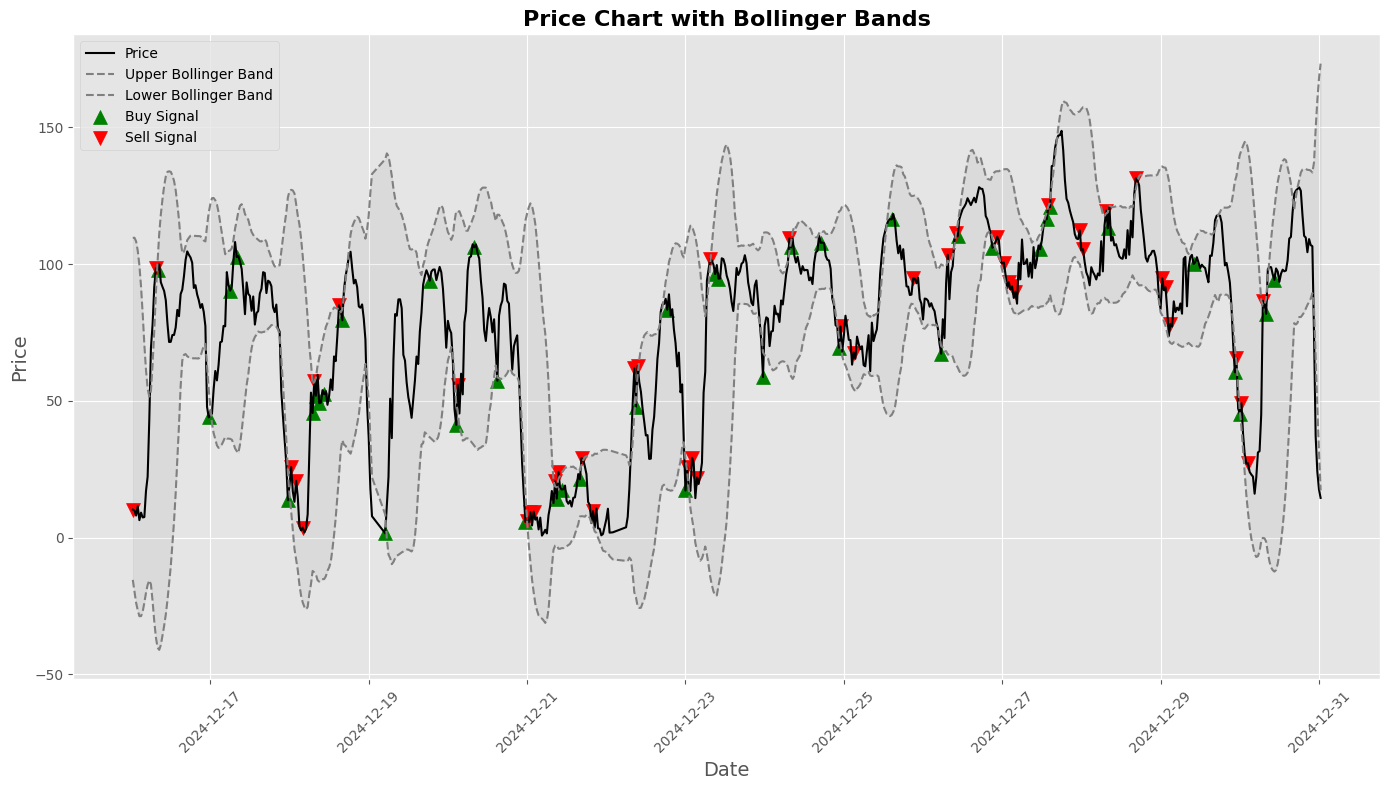

In [12]:
def plot_bollinger_bands(data):
    """
    Plots the price along with Bollinger Bands and highlights trade signals.

    """
    latest_date = data.index.max()
    half_month_ago = latest_date - pd.DateOffset(days=15)
    df_filtered = data[data.index >= half_month_ago]

    fig, ax = plt.subplots(figsize=(14, 8))

    ax.plot(df_filtered.index, df_filtered['Price'], color='black', label='Price', linewidth=1.5)

    ax.plot(df_filtered.index, df_filtered['Upper_Band'], label='Upper Bollinger Band', linestyle='--', color='grey')
    ax.plot(df_filtered.index, df_filtered['Lower_Band'], label='Lower Bollinger Band', linestyle='--', color='grey')
    ax.fill_between(df_filtered.index, df_filtered['Upper_Band'], df_filtered['Lower_Band'], color='grey', alpha=0.1)

    buy_signals = df_filtered[df_filtered['Trend_Signal'] == 1]
    sell_signals = df_filtered[df_filtered['Trend_Signal'] == -1]
    ax.scatter(buy_signals.index, buy_signals['Price'], color='green', marker='^', s=100, label='Buy Signal')
    ax.scatter(sell_signals.index, sell_signals['Price'], color='red', marker='v', s=100, label='Sell Signal')

    ax.set_title('Price Chart with Bollinger Bands', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Price', fontsize=14)
    ax.legend()
    ax.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_bollinger_bands(Data)


**TRADING STRATEGY FOR SIGNAL GENERATION**

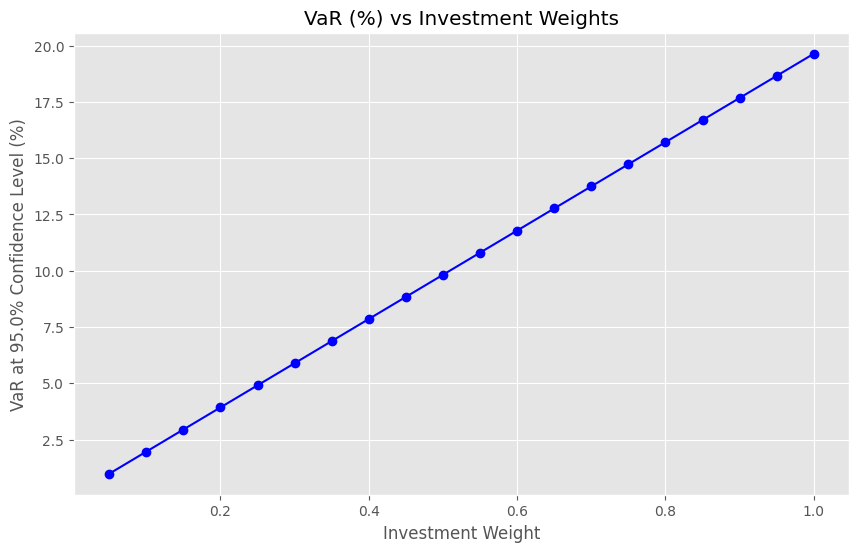

In [13]:
def plot_var_vs_weights(data, price_column='Price', max_weight=1.0, step=0.05, confidence_level=0.05):

    data = data.copy()

    # Calculate daily returns
    data['Returns'] = data[price_column].pct_change()

    # Drop any rows with NaN values
    data.dropna(inplace=True)

    weights = np.arange(step, max_weight + step, step)

    var_percentages = []

    for weight in weights:
        # Scaling the returns by the current weight
        scaled_returns = data['Returns'] * weight

        # Calculate the VaR
        VaR = np.percentile(scaled_returns, 100 * confidence_level)
        var_percentages.append(-VaR * 100)

    plt.figure(figsize=(10, 6))
    plt.plot(weights, var_percentages, marker='o', linestyle='-', color='b')
    plt.title('VaR (%) vs Investment Weights')
    plt.xlabel('Investment Weight')
    plt.ylabel(f'VaR at {100 * (1 - confidence_level)}% Confidence Level (%)')
    plt.grid(True)
    plt.show()

plot_var_vs_weights(Analysis_Data)


In [14]:
def add_signals_and_weights(data):
    data.dropna(inplace=True)

    # 'Bullish' with a 'Trend_Signal' of 1, or 'Bearish' with a 'Trend_Signal' of -1 and 0 otherwise.
    data['Signal'] = np.where(
        ((data['Regime'] == 'Bullish') & (data['Trend_Signal'] == 1)) |
        ((data['Regime'] == 'Bearish') & (data['Trend_Signal'] == -1)),
        data['Trend_Signal'],
        0
    )

    # Assign a weight of 0.1 if 'Hour_Regime' matches 'Signal' and 0.05 otherwise.
    data['Weights'] = np.where(
        (data['Hour_Regime'] == 1) & (data['Signal'] == 1), 0.1,
        np.where(
            (data['Hour_Regime'] == -1) & (data['Signal'] == -1), 0.1,
            0.05
        )
    )

add_signals_and_weights(Data)
add_signals_and_weights(Analysis_Data)

**ELIMINATING LOOKAHEAD BIAS**

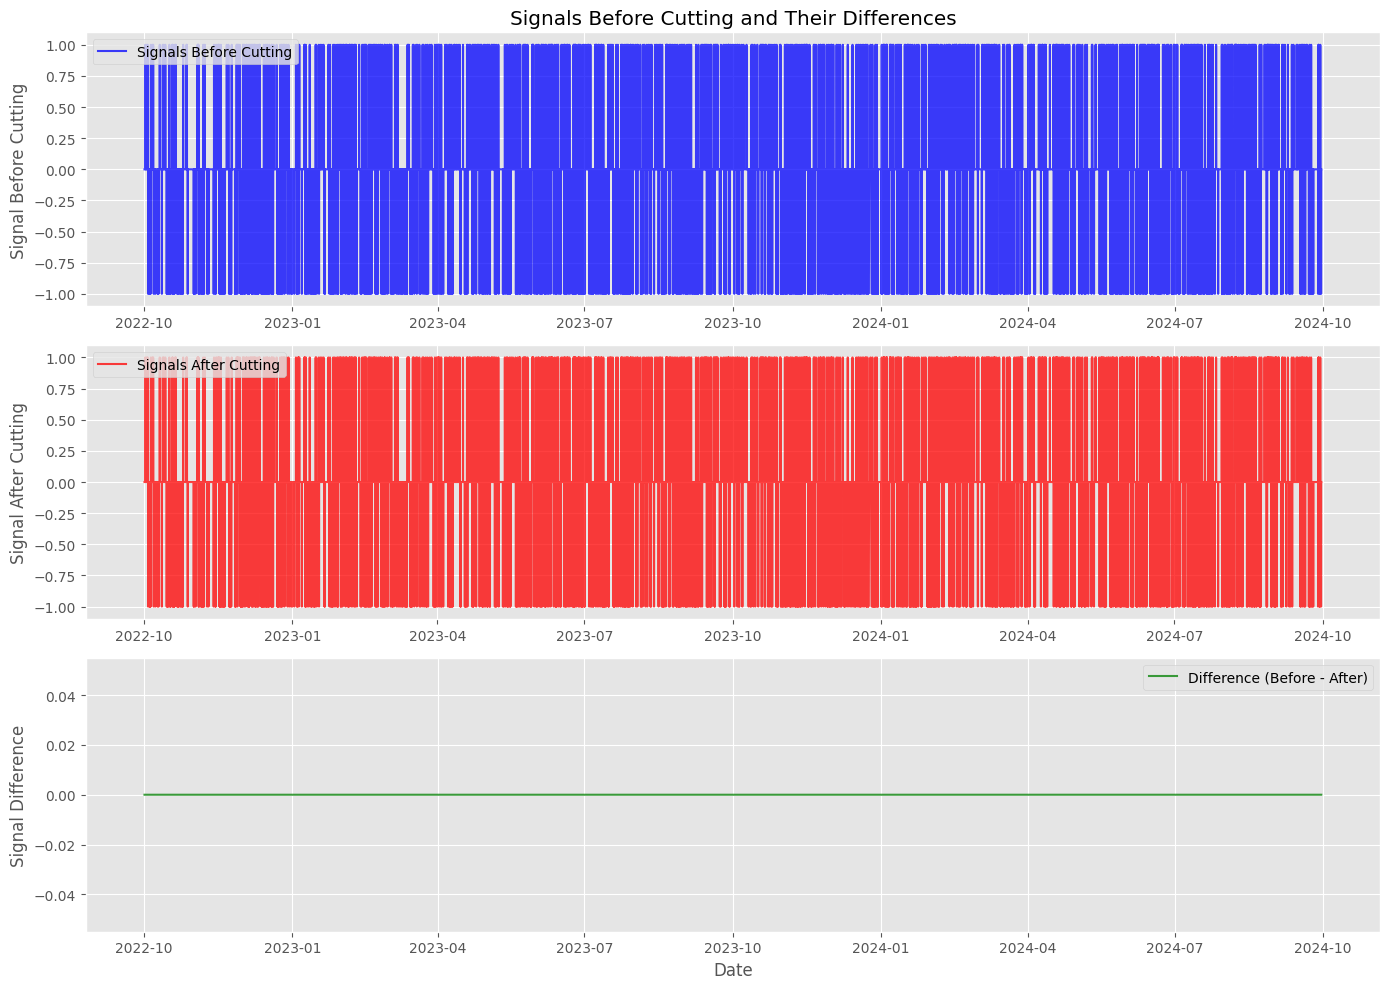

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

def compare_signals_and_plot_difference(df_cut, df_full):
    """
    This function plots the signals from two DataFrames and the differences between them.
    It assumes that the DataFrames have a 'Signal' column and are indexed by datetime.
    """
    # Check and convert index to datetime if necessary
    if not pd.api.types.is_datetime64_any_dtype(df_cut.index):
        df_cut.index = pd.to_datetime(df_cut.index)
    if not pd.api.types.is_datetime64_any_dtype(df_full.index):
        df_full.index = pd.to_datetime(df_full.index)

    # Align the full data to the date range of the cut data
    last_date_in_cut = df_cut.index.max()
    df_full_aligned = df_full[df_full.index < last_date_in_cut]

    # Calculate the difference between the signals
    df_full_aligned['Signal_Difference'] = df_full_aligned['Signal'] - df_cut['Signal']

    # Plotting the signals and their differences
    plt.figure(figsize=(14, 10))

    plt.subplot(3, 1, 1)
    plt.plot(df_full_aligned['Signal'], label='Signals Before Cutting', color='blue', alpha=0.75)
    plt.title('Signals Before Cutting and Their Differences')
    plt.ylabel('Signal Before Cutting')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(df_cut['Signal'], label='Signals After Cutting', color='red', alpha=0.75)
    plt.ylabel('Signal After Cutting')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(df_full_aligned['Signal_Difference'], label='Difference (Before - After)', color='green', alpha=0.75)
    plt.xlabel('Date')
    plt.ylabel('Signal Difference')
    plt.legend()

    plt.tight_layout()
    plt.show()

compare_signals_and_plot_difference(df_cut=Analysis_Data, df_full=Data)


In [16]:
Data.columns

Index(['DataProvider', 'SettlementDate', 'SettlementPeriod', 'Price', 'Volume',
       'Price Change', 'ATR', 'Log_Return', 'CUSUM_Pos', 'CUSUM_Neg', 'Regime',
       'Color', 'Hour_Regime', 'SMA', 'STD', 'Upper_Band', 'Lower_Band',
       'Price_Change', 'ZigZag', 'Trend_Signal', 'Position', 'Prev_High',
       'Prev_Low', 'Signal', 'Weights'],
      dtype='object')

**LAST 3 MONTHS DATA**

In [17]:
Backtest_Data = Data[Data.index >= Three_Months_Ago] # Data for Backtesting Period

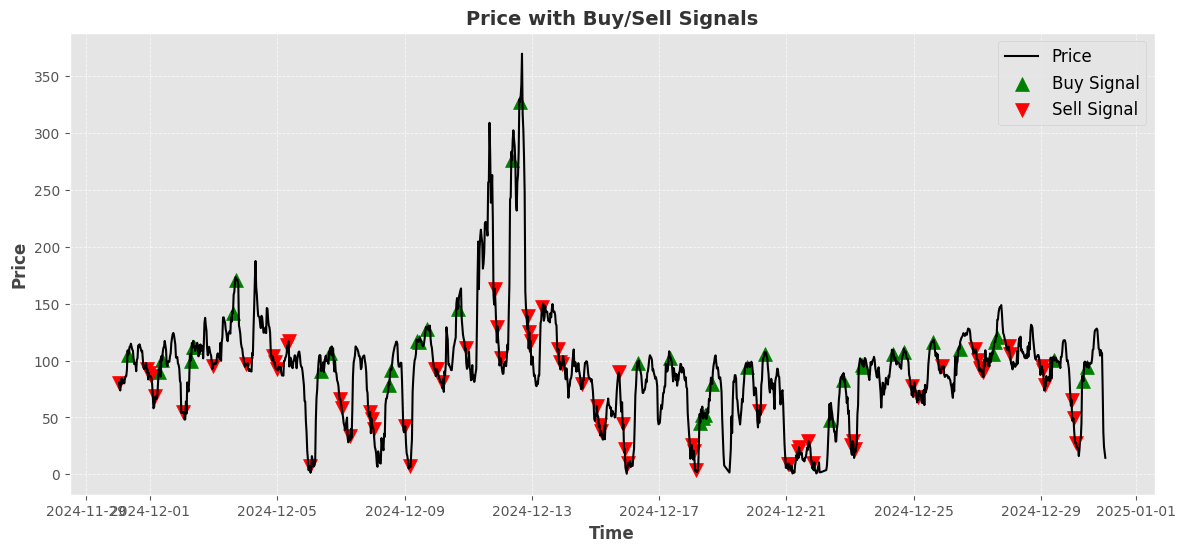

In [18]:
def plot_trading_signals(data, price_column='Price', signal_column='Signal', lookback_period='1M'):
    """
    Plots trading signals on price data over the specified lookback period.

    """
    latest_date = data.index.max()
    one_months_ago = latest_date - pd.DateOffset(months=1)
    df_filtered = data[data.index >= one_months_ago]

    df_filtered[signal_column] = pd.to_numeric(df_filtered[signal_column], errors='coerce')

    buy_signals = df_filtered[df_filtered[signal_column] > 0]
    sell_signals = df_filtered[df_filtered[signal_column] < 0]

    plt.figure(figsize=(14, 6))
    plt.plot(df_filtered.index, df_filtered[price_column], color='black', linewidth=1.5, label="Price")
    plt.scatter(buy_signals.index, buy_signals[price_column], marker='^', color='green', s=100, label="Buy Signal")
    plt.scatter(sell_signals.index, sell_signals[price_column], marker='v', color='red', s=100, label="Sell Signal")

    plt.title('Price with Buy/Sell Signals', fontsize=14, fontweight='bold', color='#333333')
    plt.xlabel('Time', fontsize=12, fontweight='bold', color='#444444')
    plt.ylabel('Price', fontsize=12, fontweight='bold', color='#444444')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

    plt.show()

plot_trading_signals(Backtest_Data)

In [19]:
Data.head()

,DataProvider,SettlementDate,SettlementPeriod,Price,Volume,Price Change,ATR,Log_Return,CUSUM_Pos,CUSUM_Neg,...,Upper_Band,Lower_Band,Price_Change,ZigZag,Trend_Signal,Position,Prev_High,Prev_Low,Signal,Weights
StartTime,,,,,,,,,,,,,,,,,,,,,
2022-10-01 07:30:00+00:00,APXMIDP,2022-10-01,18.0,154.87,1100.75,31.67,26.587857,0.228777,2.242500,-0.124975,...,196.872170,-26.722939,31.67,Flat,0,0,177.25,15.96,0,0.05
2022-10-01 08:00:00+00:00,APXMIDP,2022-10-01,19.0,183.38,1077.25,28.51,27.480000,0.168974,2.406475,0.000000,...,211.672277,-27.479420,28.51,Down,0,0,177.25,15.96,0,0.05
2022-10-01 08:30:00+00:00,APXMIDP,2022-10-01,20.0,168.20,1160.20,15.18,29.262857,-0.086407,2.315068,-0.081407,...,218.913739,-24.573739,-15.18,Flat,0,0,183.38,15.96,0,0.05
2022-10-01 09:00:00+00:00,APXMIDP,2022-10-01,21.0,145.66,1200.90,22.54,27.020714,-0.143879,2.166190,-0.220285,...,220.289157,-19.887907,-22.54,Flat,0,0,183.38,15.96,0,0.05
2022-10-01 09:30:00+00:00,APXMIDP,2022-10-01,22.0,107.90,1101.55,37.76,28.545000,-0.300070,1.861119,-0.515356,...,216.988715,-15.681656,-37.76,Flat,0,0,183.38,15.96,0,0.05


**BACKTESTING**

In [20]:
def backtest(data, initial_capital=10000):

    capital = initial_capital  # Starting capital
    position = 0
    portfolio_values = []
    positions = []
    purchase_price = 0  # Price at which the last trade was made

    for index, row in data.iterrows():
        signal = row['Signal']
        price = row['Price']
        trade_weight = row['Weights']
        hour = index.hour
        minute = index.minute

        """Realizing partial profits and stop-loss"""
        if position > 0:
            Returns = ((price - purchase_price) / purchase_price) * 100
            if Returns >= 5:
                capital += position * 0.6 * price  # Realize 60% of the position
                position *= 0.4
                purchase_price = price
            elif Returns <= -2:  # Stop loss if returns fall to -2%
                capital += position * price  # Sell all of the position
                position = 0
                purchase_price = 0

        elif position < 0:
            Returns = ((purchase_price - price) / purchase_price) * 100
            if Returns >= 5:
                capital -= abs(position) * 0.6 * price  # Cover 60% of the short position
                position *= 0.4
                purchase_price = price
            elif Returns <= -2:  # Stop loss if losses exceed 2%
                capital -= abs(position) * price  # Cover all of the short position
                position = 0
                purchase_price = 0

        # Execute trades based on the signal and weight
        if signal == 1 and capital >= (capital * trade_weight) and price > 0:
            trade_size = (capital * trade_weight) // price
            position += trade_size
            purchase_price = price
            capital -= trade_size * price
        elif signal == -1 and capital >= (capital * trade_weight) and price > 0:
            trade_size = (capital * trade_weight) // price
            position -= trade_size
            purchase_price = price
            capital += trade_size * price

        # End of day position squaring
        if hour == 23 and minute == 30:
            capital += position * price
            position = 0
            purchase_price = 0

        # Calculate the current portfolio value and record it
        portfolio_value = capital + position * price
        portfolio_values.append(portfolio_value)
        positions.append(position)

    # Append calculated portfolio values and positions to the DataFrame
    data['Portfolio_Value'] = portfolio_values
    data['Positions'] = positions
    return data

backtest_results = backtest(Backtest_Data)

backtest_results.to_csv('Trades_Data_Backtest.csv', index=False)

**RESULT VISUALIZATION**

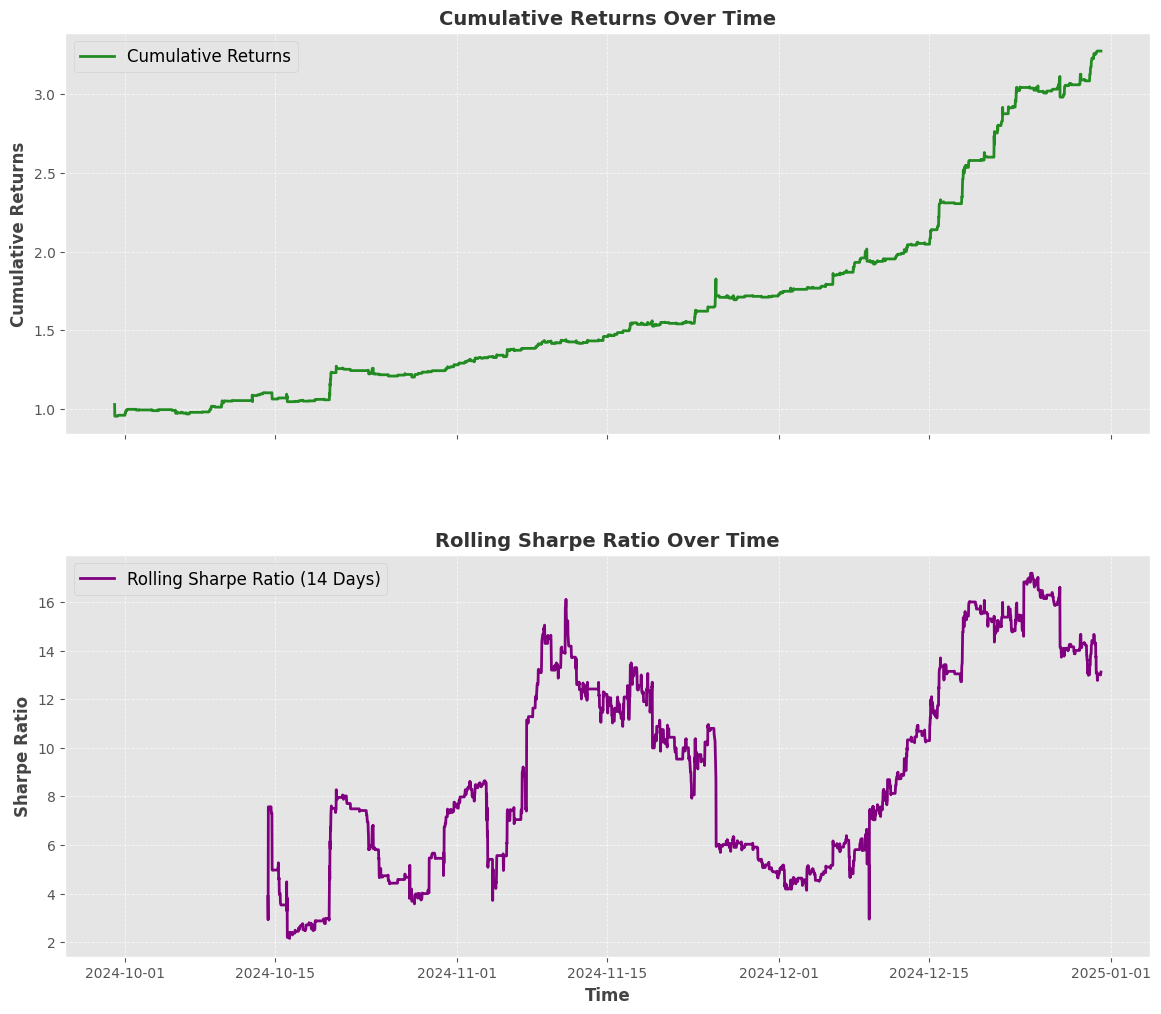


Annualized Sharpe Ratio: 7.68
Maximum Drawdown: -7.25%
Annualized Volatility: 44.89%
Sortino Ratio: 4.37


In [29]:
backtest_results['Portfolio_Value'] = pd.to_numeric(backtest_results['Portfolio_Value'], errors='coerce')
backtest_results['Returns'] = backtest_results['Portfolio_Value'].pct_change()

backtest_results['Cumulative_Returns'] = (1 + backtest_results['Returns']).cumprod()

rolling_window = 48*14
backtest_results['Rolling_Sharpe'] = (backtest_results['Returns'].rolling(rolling_window).mean() /
                                      backtest_results['Returns'].rolling(rolling_window).std()) * np.sqrt(48 * 252)

backtest_results['Cumulative_Max'] = backtest_results['Cumulative_Returns'].cummax()
backtest_results['Drawdown'] = backtest_results['Cumulative_Returns'] / backtest_results['Cumulative_Max'] - 1

sharpe_ratio = (backtest_results['Returns'].mean() / backtest_results['Returns'].std()) * np.sqrt(48 * 252)

max_drawdown = backtest_results['Drawdown'].min()

volatility = backtest_results['Returns'].std() * np.sqrt(48 * 252)

downside_returns = backtest_results['Returns'][backtest_results['Returns'] < 0]
sortino_ratio = (backtest_results['Returns'].mean() / downside_returns.std()) * np.sqrt(48 * 252)


fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
plt.subplots_adjust(hspace=0.3)


axes[0].plot(backtest_results.index, backtest_results['Cumulative_Returns'], label='Cumulative Returns', color='#228b22', linewidth=2)
axes[0].set_title('Cumulative Returns Over Time', fontsize=14, fontweight='bold', color='#333333')
axes[0].set_ylabel('Cumulative Returns', fontsize=12, fontweight='bold', color='#444444')
axes[0].legend(fontsize=12)
axes[0].grid(True, linestyle='--', linewidth=0.6, alpha=0.7)


axes[1].plot(backtest_results.index, backtest_results['Rolling_Sharpe'], label='Rolling Sharpe Ratio (14 Days)', color='#800080', linewidth=2)
axes[1].set_title('Rolling Sharpe Ratio Over Time', fontsize=14, fontweight='bold', color='#333333')
axes[1].set_xlabel('Time', fontsize=12, fontweight='bold', color='#444444')
axes[1].set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold', color='#444444')
axes[1].legend(fontsize=12)
axes[1].grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

plt.show()
print()
print(f"\033[1mAnnualized Sharpe Ratio:\033[0m {sharpe_ratio:.2f}")
print(f"\033[1mMaximum Drawdown:\033[0m {max_drawdown:.2%}")
print(f"\033[1mAnnualized Volatility:\033[0m {volatility:.2%}")
print(f"\033[1mSortino Ratio:\033[0m {sortino_ratio:.2f}")


In [22]:
backtest_results.to_csv('backtest_results.csv')

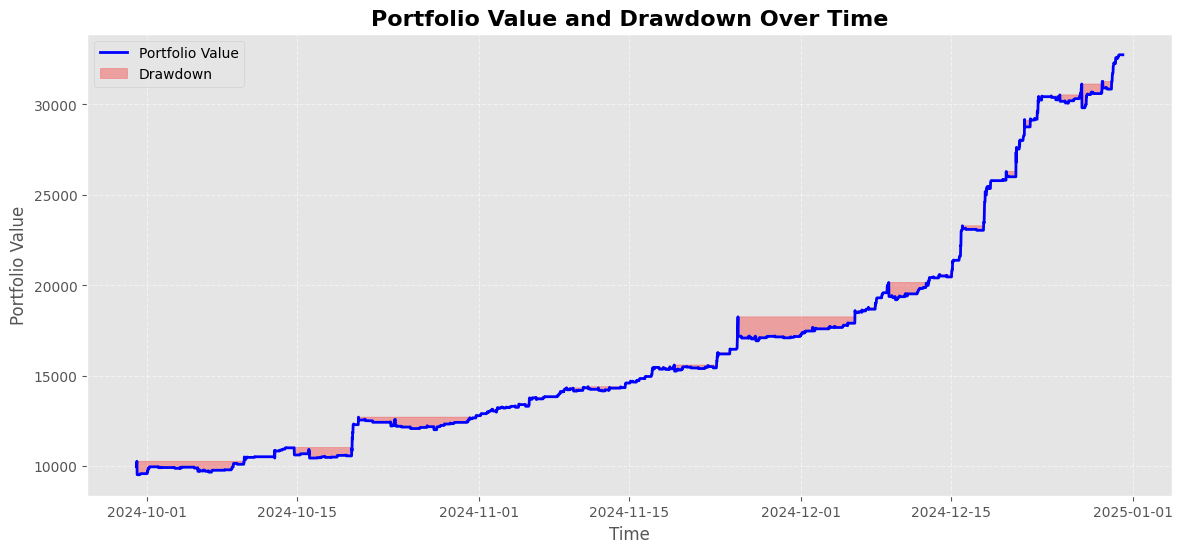

In [30]:
backtest_results['Cumulative_Max'] = backtest_results['Portfolio_Value'].cummax()
backtest_results['Drawdown'] = 1 - (backtest_results['Portfolio_Value'] / backtest_results['Cumulative_Max'])

plt.figure(figsize=(14, 6))
plt.plot(backtest_results.index, backtest_results['Portfolio_Value'], label='Portfolio Value', color='blue', linewidth=2)
plt.fill_between(backtest_results.index, backtest_results['Portfolio_Value'], backtest_results['Cumulative_Max'], where=backtest_results['Portfolio_Value'] < backtest_results['Cumulative_Max'], color='red', alpha=0.3, label='Drawdown')

plt.title('Portfolio Value and Drawdown Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Portfolio Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


**Hypothesis Testing**

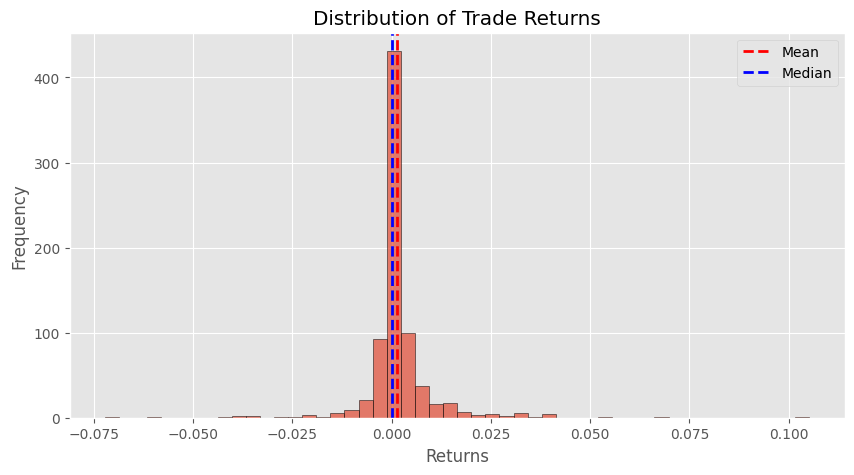

{'T-test Statistic': 3.862851166803106,
 'P-value': 0.0001215100474260396,
 'Mean Return': 0.001320477907650119,
 '95% CI (Lower)': 0.0006524285417946101,
 '95% CI (Upper)': 0.0019835013813117256,
 'Win Rate (%)': 40.909090909090914,
 'Profit Factor': 1.9405861678011012,
 'Total Profit': 2.0977619729586197,
 'Total Loss': 1.0809939840680283}

In [23]:
from scipy import stats

df = backtest_results

df['Trade_Taken'] = df['Positions'].diff().ne(0)  # Identify when position changes (new trade entry)
trade_returns = df.loc[df['Trade_Taken'], 'Returns'].dropna()

# T-test for statistical significance
t_stat, p_value = stats.ttest_1samp(trade_returns, 0)

total_profit = trade_returns[trade_returns > 0].sum()
total_loss = abs(trade_returns[trade_returns < 0].sum())
profit_factor = total_profit / total_loss if total_loss != 0 else float('inf')

# Win rate calculation
win_rate = (trade_returns > 0).mean() * 100

# Confidence Interval using bootstrapping
bootstrap_means = np.random.choice(trade_returns, size=(1000, len(trade_returns)), replace=True).mean(axis=1)
ci_lower, ci_upper = np.percentile(bootstrap_means, [2.5, 97.5])

final_results = {
    "T-test Statistic": t_stat,
    "P-value": p_value,
    "Mean Return": trade_returns.mean(),
    "95% CI (Lower)": ci_lower,
    "95% CI (Upper)": ci_upper,
    "Win Rate (%)": win_rate,
    "Profit Factor": profit_factor,
    "Total Profit": total_profit,
    "Total Loss": total_loss,
}

plt.figure(figsize=(10, 5))
plt.hist(trade_returns, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(trade_returns.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(trade_returns.median(), color='blue', linestyle='dashed', linewidth=2, label='Median')
plt.legend()
plt.title('Distribution of Trade Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

final_results